In [146]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  

**Описание задачи** 

Необходимо сегментировать клиентов торгового центра, чтобы дать рекомендации отделу маркетинга по коммуникации с каждым сегментом. По мотивам соревнования на Kaggle https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python

In [147]:
dataset = pd.read_csv('Mall_Customers.csv')

In [148]:
dataset.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [149]:
### Возьмем для кластеризации два основных признака - это доход и уровень затрат.
X= dataset.iloc[:, [3,4]].values

Проверим несколько алгоритом кластеризации, но сначала определим оптимальное количество кластеров

**Выбор оптимального количества кластеров**

Вариант 1. **Метод "локтя"** 

Сумма квадратов расстояний от точек до центроидов кластеров. 

In [150]:
from sklearn.cluster import KMeans
wcss=[]

#возьмем для начала 10 кластеров, чтобы выбрать оптимальное количество 
for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

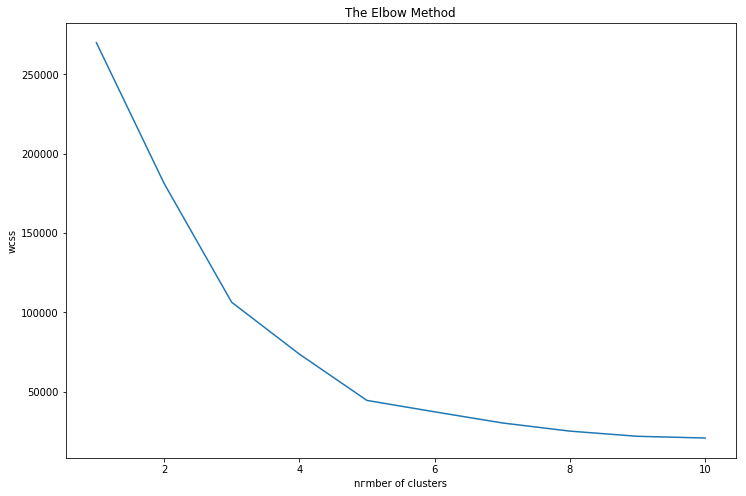

In [151]:
#Визуализируем метод "локтя"
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method')
plt.xlabel('nгmber of clusters')
plt.ylabel('wcss')
plt.show()

Начиная с 5 кластера идет плавный переход до 10. Примем 5 кластеров, как оптимальное количество кластеров, но проверим его еще одним способом.

Вариант 2. **Agglomerative Hierarchical Clustering**

Дендрограмма для агломеративной кластеризации

In [152]:
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 

In [153]:
dist = distance_matrix(X, X)

In [154]:
Z = hierarchy.linkage(dist, 'complete')

/Users/OzzyPeople/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


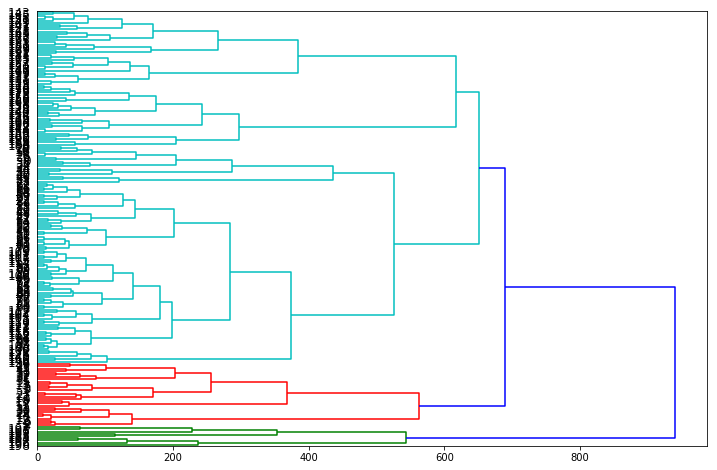

In [155]:
plt.figure(figsize=(12, 8))
dendro = hierarchy.dendrogram(Z, leaf_rotation=0, leaf_font_size=12, orientation='right')

Если посмотрим на верхний "треугольник", то увидим 5 основных групп. Результат перекликается с методом "локтя".

**Резюме**

5 - оптимальное количество кластеров.

**Построение моделей**

**K-means**

In [156]:
#Строим модель KMeans, 'k-means++' - улучшенная версия поиска начальных значений центроидов 

kmeansmodel = KMeans(n_clusters= 5, init='k-means++', random_state=0)
y_kmeans= kmeansmodel.fit_predict(X)

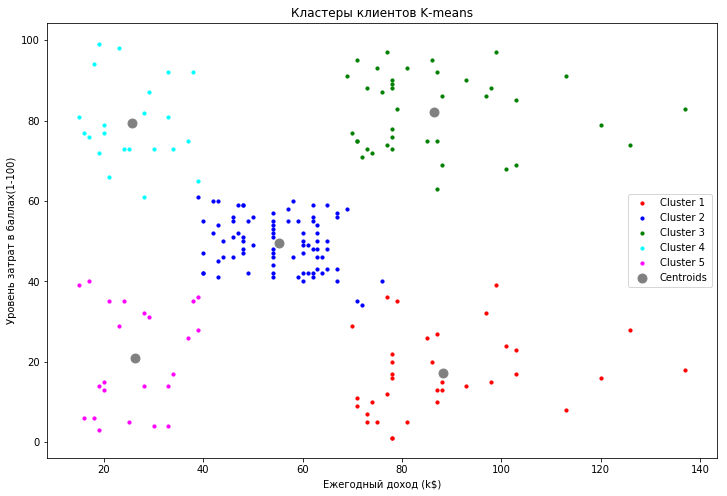

In [157]:
#Построим все точки, кластеры и центроиды
plt.figure(figsize=(12, 8))
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 10, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 10, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 10, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 10, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 10, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeansmodel.cluster_centers_[:, 0], kmeansmodel.cluster_centers_[:, 1], s = 80, c = 'grey', label = 'Centroids')
plt.title('Кластеры клиентов K-means')
plt.xlabel('Ежегодный доход (k$)')
plt.ylabel('Уровень затрат в баллах(1-100)')
plt.legend()
plt.show()

**Agglomerative Clustering**

In [158]:
from sklearn.cluster import AgglomerativeClustering 
agglom = AgglomerativeClustering(n_clusters=5, linkage='average').fit(X)

In [160]:
dataset.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),labels_agglom
0,1,Male,19,15,39,1
1,2,Male,21,15,81,3
2,3,Female,20,16,6,1
3,4,Female,23,16,77,3
4,5,Female,31,17,40,1


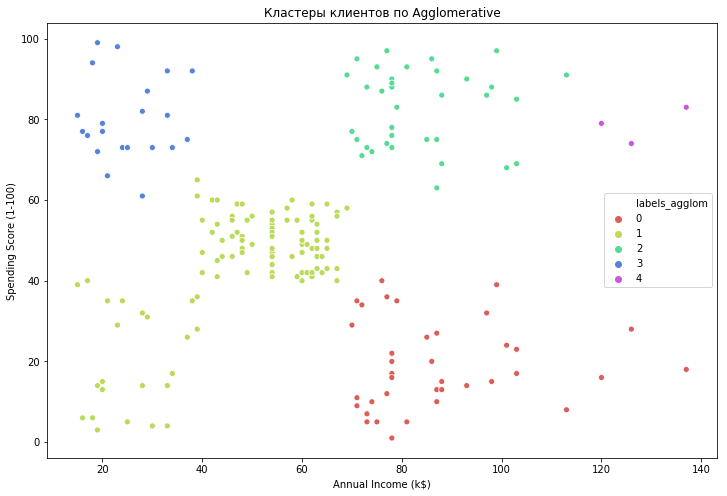

In [161]:
dataset['labels_agglom'] = agglom.labels_
plt.figure(figsize=(12, 8))
sns.scatterplot(dataset['Annual Income (k$)'], dataset['Spending Score (1-100)'], hue=dataset['labels_agglom'], 
                palette=sns.color_palette('hls', 5))
plt.title('Кластеры клиентов по Agglomerative')
plt.show()

**DBSCAN**

In [163]:
from sklearn.cluster import DBSCAN 
db = DBSCAN(eps=11, min_samples=6).fit(X)

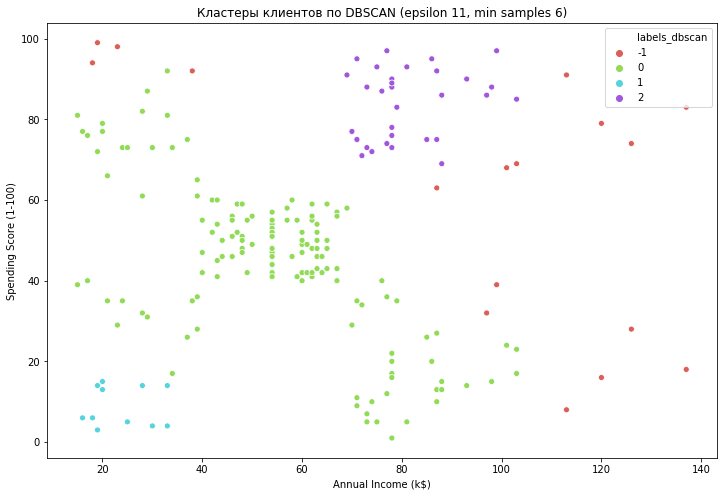

In [164]:
dataset['labels_dbscan'] = db.labels_
plt.figure(figsize=(12, 8))
sns.scatterplot(dataset['Annual Income (k$)'], dataset['Spending Score (1-100)'], hue=dataset['labels_dbscan'], 
                palette=sns.color_palette('hls', np.unique(db.labels_).shape[0]))
plt.title('Кластеры клиентов по DBSCAN (epsilon 11, min samples 6)')
plt.show()

**Оценка качества**

Так как нам неизвестны истинные метки объектов, используем показатель оценки качества Silhouette. Он показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров.  

In [165]:
from sklearn import metrics

In [166]:
algorithms = []
algorithms.append(KMeans(n_clusters= 5, init='k-means++', random_state=0))
algorithms.append(AgglomerativeClustering(n_clusters=5, linkage='average'))
algorithms.append(DBSCAN(eps=11, min_samples=6))

In [167]:
data = []
for algo in algorithms:
    algo.fit(X)
    data.append(({'Silhouette': metrics.silhouette_score(X, algo.labels_)}))
results = pd.DataFrame(data=data, columns=['Silhouette'],
                       index=['K-means', 'Agglomerative', 'DBSCAN'])
results

,Silhouette
K-means,0.553932
Agglomerative,0.479191
DBSCAN,0.313644


**Анализ результатов**

Интерпретируем данные по модели K-means, так как она показала лучший результат.

In [168]:
# Создадим колонку принадлежности к кластеру
dataset['labels'] = y_kmeans

In [173]:
dataset.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),labels_agglom,labels_dbscan,labels
0,1,Male,19,15,39,1,0,4
1,2,Male,21,15,81,3,0,3
2,3,Female,20,16,6,1,1,4
3,4,Female,23,16,77,3,0,3
4,5,Female,31,17,40,1,0,4


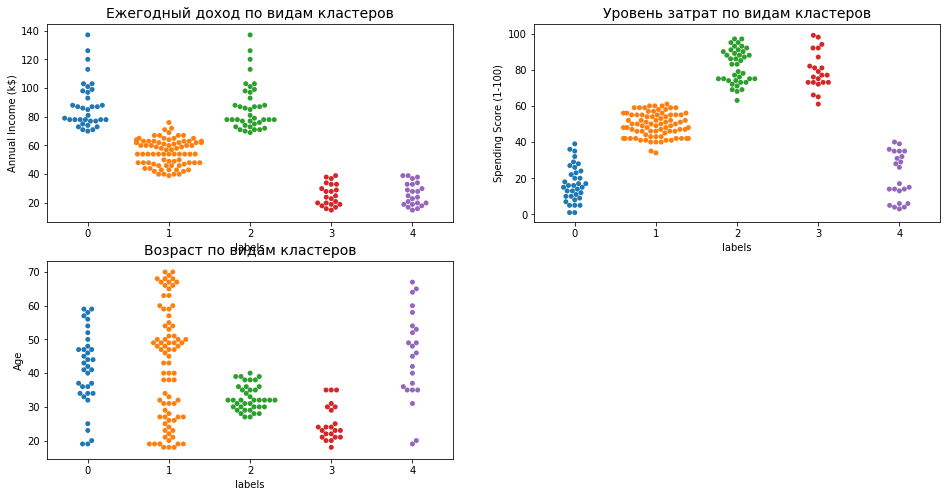

In [181]:
#Визуализируем кластеры по уровню дохода и затратам

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(221)
sns.swarmplot(x='labels', y='Annual Income (k$)', data=dataset, ax=ax)
ax.set_title('Ежегодный доход по видам кластеров', fontsize = 14)

ax = fig.add_subplot(222)
sns.swarmplot(x='labels', y='Spending Score (1-100)', data=dataset, ax=ax )
ax.set_title('Уровень затрат по видам кластеров', fontsize = 14)

ax = fig.add_subplot(223)
sns.swarmplot(x='labels', y='Age', data=dataset, ax=ax )
ax.set_title('Возраст по видам кластеров', fontsize = 14)

plt.show()

**Рекомендаций для маркетинга**

**Приоритетные кластеры** 

Больше всех покупают и по возрасту наиболее активные. Между собой они отличаются по возрасту и уровнем дохода.

1) **средний класс** - кластер 2. Это более зрелые люди  от 28 до 40 лет, скорее всего семейные (надо проверить). Поэтому коммуникация должна быть направлена на семейные ценности, покупки и время провождения для всей семьи. Активное потребление, кредитные программы, новые бизнес модели, например, подписка на торговый центр, новые услуги - доставка и праздники для всей семьи. Чем больше времени они проводят в торговом центре, тем лучше. 

2) **активная молодежь** - кластер 3. Cтоит обратить внимание на их "юность" и манеру общения, а также низкий уровень дохода, проанализировать типичную корзину потребления.

По каждой группе стоит сделать предложения по клубу лояльности, поощрения, cross-sale, member-get-member программы, активное продвижение мобильного приложения и персональные рекомендации с учетом особенности их потребления и каналов коммуникации (социальные сети, мессенджеры).


**Источник роста**

Кластер номер 1. У него средний уровень потребления, есть деньги и потребности. Его надо переводить на уровень активного клиента, используя скидки и перспективы лояльного клиента, рекомендации по схожему профилю уже лояльных клиентов.

**Территория забвения**

Кластер 0 и 4 могут пока подождать, когда уже потенциал развития предыдущих будет исчерпан.